In [1]:
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
# import cv2

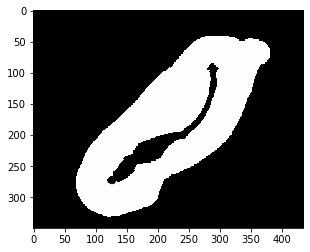

In [2]:
import cv2
img=cv2.imread('columbia_tuned.pgm',0)
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(img,cmap='gray')

981.8275502920151 643.5533835887909


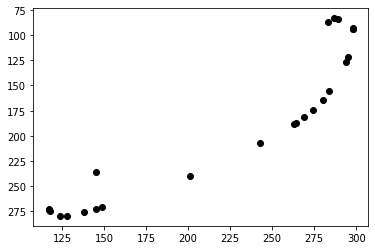

In [35]:
import numpy as np
import cv2 as cv
# from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from matplotlib import pyplot as plt
%matplotlib inline

# process image, get in and out contours
im = cv.imread('columbia_tuned.pgm')
imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(im, contours, -1, (0,0,255), 3)

arc_out=cv.arcLength(contours[0],True)
arc_in=cv.arcLength(contours[1],True)
print(arc_out,arc_in)

out_cnt=np.asarray(contours[0])
out_cnt=np.reshape(out_cnt,(-1,2))
out_cnt=np.vstack((out_cnt,out_cnt[0,:]))
# compute convex hull of in contour
in_cnt=cv.convexHull(contours[1])
in_cnt=np.asarray(in_cnt)

# nonconvexhull
# in_cnt=np.asarray(contours[1])


in_cnt=np.reshape(in_cnt,(-1,2))
in_cnt=np.vstack((in_cnt,in_cnt[0,:]))


x,y=in_cnt[:,0],in_cnt[:,1]
plt.plot(x,y, 'ok',label='poly')
# plt.axes.Axes.invert_yaxis
ax = plt.gca()
ax.invert_yaxis()
plt.show()

(100, 2)
(100, 2)
205.0 673 554
(99, 2) (99, 1) (100, 2)


/home/lance/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


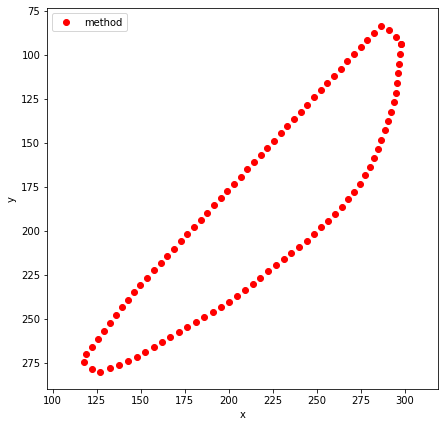

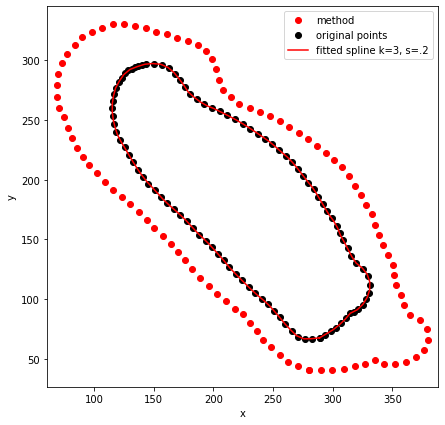

In [199]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import pdb
# interpolate
# fit spline
def interp_line(points,n):
    
    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]
#     print('distance',distance)
    alpha = np.linspace(0, 1, n)
#     alpha=np.arange(0,n,1)
    interpolated_points = {}
#     method='cubic'
#     method='quadratic'
    method='slinear'
    interpolator =  interp1d(distance, points, kind=method, axis=0)
    interpolated_points['method'] = interpolator(alpha)
    plt.figure(figsize=(7,7))
    for method_name, curve in interpolated_points.items():
        plt.plot(*curve.T, 'or', label=method_name);
    print(curve.shape)
    plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y');
    ax = plt.gca()
    ax.invert_yaxis()
    return curve
    

def fit_spline(points,n):

    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]
    splines = [UnivariateSpline(distance, coords, k=3, s=.2) for coords in points.T]
    alpha = np.linspace(0, 1, n)
    points_fitted = np.vstack( spl(alpha) for spl in splines ).T
    # Graph:
    plt.plot(*points.T, 'ok', label='original points');
    plt.plot(*points_fitted.T, '-r', label='fitted spline k=3, s=.2');
    plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y');
    ax = plt.gca()
    ax.invert_yaxis()
    return points_fitted

n=100
# n=100
points_in = interp_line(in_cnt,n)
points_out = interp_line(out_cnt,n)
points_in=np.flip(points_in,0)


intersect_pts,ids_in,ids_out=np.intersect1d(points_in[:,0], points_out[:,0],return_indices=True)
for i in range(len(intersect_pts)):
    id_in=ids_in[i]
    id_out=ids_out[i]
    intersect_pt=intersect_pts[i]
    if np.abs(points_in[id_in,1]-points_out[id_out,1])<50:
        break
print(intersect_pt,id_in,id_out)
id_in,id_out=int(id_in),int(id_out)
new_in=np.vstack((points_in[id_in:,:],points_in[:id_in,:]))
new_out=np.vstack((points_out[id_out:,:],points_out[:id_out,:]))


weight=0.5
raceline=weight*new_in + (1-weight)*new_out
# use cubic spline to fit the traj
raceline=fit_spline(raceline,n)
# create new samples
# uniform distribution
# delta = abs(new_in-new_out)
# norm=np.sqrt(np.sum(delta**2,axis=1))
# norm=np.reshape(norm,(-1,1))
# new_norm=np.tile(norm,2)
# unit_delta = delta/new_norm
# per_unit=np.hstack(unit_delta[:,1],-unit_delta[:,0])
# print(new_norm.shape,unit_delta.shape)
# create ramdon number
# rand_num=(np.random.rand(n,1)-0.5)
# sample_raceline = np.tile(rand_num,2)*delta + raceline 
delta=np.diff(raceline, axis=0)
# delta.shape
norm=np.sqrt(np.sum(delta**2,axis=1))
norm=np.reshape(norm,(-1,1))
new_norm=np.tile(norm,2)
unit_delta = delta/new_norm
per_unit=np.hstack((np.reshape(unit_delta[:,1],(-1,1)),-np.reshape(unit_delta[:,0],(-1,1))))
per_unit=np.insert(per_unit, 0,per_unit[0,:],axis=0)
print(unit_delta.shape,np.reshape(unit_delta[:,1],(-1,1)).shape,per_unit.shape)
rand_num=(np.random.rand(n,1)-0.5)
sample_raceline = np.tile(rand_num,2)*30 + raceline 


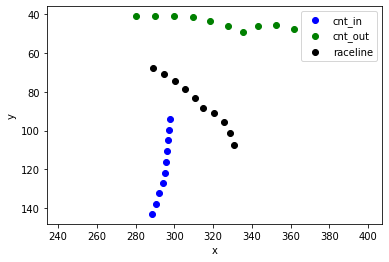

In [241]:

raceline_hull=cv.convexHull(np.reshape(raceline,(-1,1,2)).astype(int))
raceline_hull=np.reshape(raceline_hull,(-1,2))
# plot all lines
# a=0
# b=n

a=n-10
b=n

plt.plot(*new_in[a:b,:].T, 'ob',label='cnt_in')
plt.plot(*new_out[a:b,:].T, 'og',label='cnt_out')
plt.plot(*raceline[a:b,:].T, 'ok',label='raceline')
# plt.plot(*sample_raceline[a:b,:].T, 'or',label='sample raceline')
# plt.plot(*raceline_hull[a:b,:].T, 'xr',label='raceline')

# plt.plot(*new_in.T, 'ob',label='cnt_in')
# plt.plot(*new_out.T, 'og',label='cnt_out')
# plt.plot(*raceline.T, 'ok',label='raceline')
plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y');
ax = plt.gca()
ax.invert_yaxis()

In [201]:
np.savetxt('raceline.csv', raceline, delimiter=',')

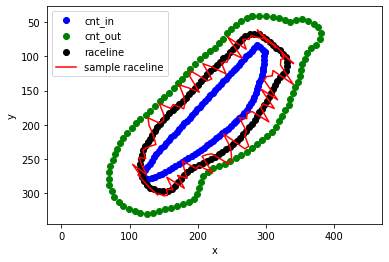

In [239]:
# fit_sample_raceline=fit_spline(sample_raceline,n)
plt.plot(*new_in[a:b,:].T, 'ob',label='cnt_in')
plt.plot(*new_out[a:b,:].T, 'og',label='cnt_out')
plt.plot(*raceline[a:b,:].T, 'ok',label='raceline')
# plt.plot(*fit_sample_raceline[a:b,:].T, 'or',label='sample raceline')
plt.plot(*sample_raceline[a:b,:].T, '-r',label='sample raceline')
plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y');
ax = plt.gca()
ax.invert_yaxis()

/home/lance/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


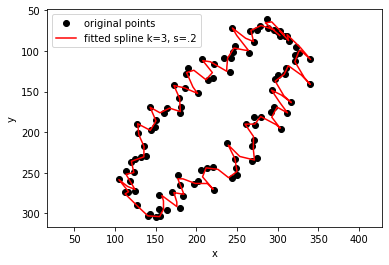

In [212]:
new_sample=fit_spline(sample_raceline,n)
# new_sample=fit_spline(new_sample,1000)

# fit_sample_raceline=fit_spline(sample_raceline,n)

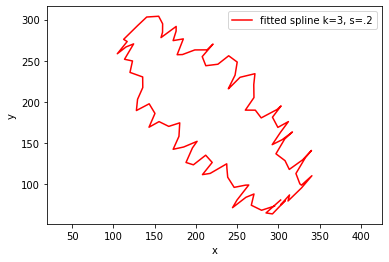

In [213]:
# plt.plot(*points.T, 'ok', label='original points');
plt.plot(*new_sample.T, '-r', label='fitted spline k=3, s=.2');
plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y');

In [220]:
cnt=np.reshape(raceline,(-1,1,2))
hull = cv2.convexHull(cnt,returnPoints = False)
# defects = cv2.convexityDefects(cnt,hull)

error: OpenCV(4.1.1) /io/opencv/modules/imgproc/src/convhull.cpp:137: error: (-215:Assertion failed) total >= 0 && (depth == CV_32F || depth == CV_32S) in function 'convexHull'


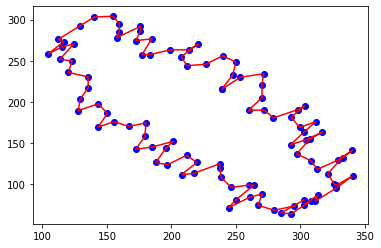

In [237]:
# B spline representation
from scipy.interpolate import splprep, splev
# x,y=raceline[:,0], raceline[:,1]
x,y=new_sample[:,0], new_sample[:,1]
tck, u = splprep([x,y], s=0)
new_points = splev(u, tck)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(x, y, 'ob')
ax.plot(new_points[0], new_points[1], '-r')
plt.show()